# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
#env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.03086462 -0.18149014 -0.04708675  0.31118283] 0 1.0 False {}
state, action, reward, done, info: [-0.03449443  0.01426992 -0.0408631   0.0040298 ] 1 1.0 False {}
state, action, reward, done, info: [-0.03420903  0.20995336 -0.0407825  -0.30126073] 1 1.0 False {}
state, action, reward, done, info: [-0.03000996  0.01543569 -0.04680772 -0.02171357] 0 1.0 False {}
state, action, reward, done, info: [-0.02970125  0.21119657 -0.04724199 -0.32878972] 1 1.0 False {}
state, action, reward, done, info: [-0.02547731  0.40695811 -0.05381778 -0.63598839] 1 1.0 False {}
state, action, reward, done, info: [-0.01733815  0.60278771 -0.06653755 -0.94512228] 1 1.0 False {}
state, action, reward, done, info: [-0.0052824   0.79873977 -0.08543999 -1.25794757] 1 1.0 False {}
state, action, reward, done, info: [ 0.0106924   0.99484486 -0.11059895 -1.57612099] 1 1.0 False {}
state, action, reward, done, info: [ 0.03058929  1.19109762 -0.14212137 -1.90115137] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
def model_input(state_size, lstm_size, batch_size=1):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # RNN-GRU
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    # Output
    return actions, states, targetQs, cell, initial_state

In [7]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [8]:
def model_outputs(action_size, hidden_size, states, cell, initial_state):
    actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
                                            lstm_size=hidden_size, num_classes=action_size)
    return actions_logits, final_state

In [13]:
def model_loss(action_size, hidden_size, states, cell, initial_state, actions, targetQs):
    actions_logits, _ = generator(states=states, cell=cell, initial_state=initial_state, 
                                  lstm_size=hidden_size, num_classes=action_size, reuse=True)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    #loss = tf.reduce_mean(tf.square(Qs - targetQs))
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
                                                                  labels=tf.nn.sigmoid(targetQs)))
    return actions_logits, loss

In [14]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, cell, self.initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)
        
        # Output of the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state = model_outputs(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, cell=cell, initial_state=self.initial_state)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [16]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

In [17]:
# episode_total_reward = deque(maxlen=10)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [18]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [19]:
# Training parameters
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

In [20]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)
(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [21]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
memory.buffer[0]

[array([-0.03863851, -0.01005985,  0.03380489, -0.0333856 ]),
 1,
 array([-0.03883971,  0.18456143,  0.03313718, -0.31521399]),
 1.0,
 0.0]

In [23]:
# states, rewards, actions

In [ ]:
# Now train with experiences
saver = tf.train.Saver() # save the trained model
rewards_list, loss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=batch_size)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([initial_state, final_state])
            total_reward += reward
            initial_state = final_state
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            initial_states = np.array([each[0] for each in rnn_states])
            final_states = np.array([each[1] for each in rnn_states])
            actions_logits = sess.run(model.actions_logits, 
                                      feed_dict = {model.states: next_states, 
                                                   model.initial_state: final_states[0].reshape([1, -1])})
            nextQs = np.max(actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (0.99 * nextQs)
#             actions_logits = sess.run(model.actions_logits,
#                                       feed_dict = {model.states: states, 
#                                                    model.initial_state: initial_states[0].reshape([1, -1])})
#             targetQs = np.max(actions_logits, axis=1)
            loss, _ = sess.run([model.loss, model.opt], 
                               feed_dict = {model.states: states, 
                                            model.actions: actions,
                                            model.targetQs: targetQs,
                                            model.initial_state: initial_states[0].reshape([1, -1])})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode: {}'.format(ep),
              'meanReward: {:.4f}'.format(np.mean(episode_reward)),
              'meanLoss: {:.4f}'.format(np.mean(loss_batch)),
              'ExploreP: {:.4f}'.format(explore_p))
        rewards_list.append([ep, np.mean(episode_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        if(np.mean(episode_reward) >= 500):
            break
    
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode: 0 meanReward: 14.0000 meanLoss: 0.5954 ExploreP: 0.9986
Episode: 1 meanReward: 18.5000 meanLoss: 0.3803 ExploreP: 0.9963
Episode: 2 meanReward: 18.6667 meanLoss: 0.2762 ExploreP: 0.9945
Episode: 3 meanReward: 18.7500 meanLoss: 0.2313 ExploreP: 0.9926
Episode: 4 meanReward: 18.2000 meanLoss: 0.1183 ExploreP: 0.9910
Episode: 5 meanReward: 17.0000 meanLoss: 0.0921 ExploreP: 0.9900
Episode: 6 meanReward: 17.8571 meanLoss: 0.1155 ExploreP: 0.9877
Episode: 7 meanReward: 17.8750 meanLoss: 0.0823 ExploreP: 0.9859
Episode: 8 meanReward: 17.4444 meanLoss: 0.0989 ExploreP: 0.9846
Episode: 9 meanReward: 17.2000 meanLoss: 0.1126 ExploreP: 0.9831
Episode: 10 meanReward: 16.6364 meanLoss: 0.1314 ExploreP: 0.9820
Episode: 11 meanReward: 16.5000 meanLoss: 0.1331 ExploreP: 0.9806
Episode: 12 meanReward: 17.6154 meanLoss: 0.0990 ExploreP: 0.9776
Episode: 13 meanReward: 18.6429 meanLoss: 0.0582 ExploreP: 0.9745
Episode: 14 meanReward: 18.6667 meanLoss: 0.0546 ExploreP: 0.9727
Episode: 15 meanRewa

Episode: 124 meanReward: 27.8438 meanLoss: 0.0376 ExploreP: 0.7448
Episode: 125 meanReward: 27.9688 meanLoss: 0.0351 ExploreP: 0.7434
Episode: 126 meanReward: 27.2188 meanLoss: 0.0511 ExploreP: 0.7418
Episode: 127 meanReward: 27.0000 meanLoss: 0.0620 ExploreP: 0.7404
Episode: 128 meanReward: 26.8125 meanLoss: 0.0575 ExploreP: 0.7386
Episode: 129 meanReward: 25.9062 meanLoss: 0.0378 ExploreP: 0.7358
Episode: 130 meanReward: 25.7500 meanLoss: 0.0396 ExploreP: 0.7336
Episode: 131 meanReward: 27.1875 meanLoss: 0.0185 ExploreP: 0.7290
Episode: 132 meanReward: 27.6250 meanLoss: 0.0362 ExploreP: 0.7272
Episode: 133 meanReward: 27.6562 meanLoss: 0.0444 ExploreP: 0.7259
Episode: 134 meanReward: 27.7812 meanLoss: 0.0658 ExploreP: 0.7247
Episode: 135 meanReward: 28.2812 meanLoss: 0.0420 ExploreP: 0.7218
Episode: 136 meanReward: 29.4375 meanLoss: 0.0161 ExploreP: 0.7183
Episode: 137 meanReward: 28.9062 meanLoss: 0.0169 ExploreP: 0.7149
Episode: 138 meanReward: 28.5625 meanLoss: 0.0645 ExploreP: 0.

Episode: 247 meanReward: 46.0938 meanLoss: 0.0630 ExploreP: 0.4776
Episode: 248 meanReward: 46.3125 meanLoss: 0.0309 ExploreP: 0.4749
Episode: 249 meanReward: 46.3125 meanLoss: 0.0415 ExploreP: 0.4743
Episode: 250 meanReward: 46.3125 meanLoss: 0.0959 ExploreP: 0.4738
Episode: 251 meanReward: 46.3125 meanLoss: 0.1298 ExploreP: 0.4733
Episode: 252 meanReward: 46.2812 meanLoss: 0.1226 ExploreP: 0.4729
Episode: 253 meanReward: 46.3438 meanLoss: 0.0969 ExploreP: 0.4721
Episode: 254 meanReward: 46.5000 meanLoss: 0.0799 ExploreP: 0.4712
Episode: 255 meanReward: 46.5312 meanLoss: 0.0681 ExploreP: 0.4705
Episode: 256 meanReward: 46.8125 meanLoss: 0.0625 ExploreP: 0.4691
Episode: 257 meanReward: 42.4688 meanLoss: 0.0467 ExploreP: 0.4680
Episode: 258 meanReward: 42.7188 meanLoss: 0.0440 ExploreP: 0.4664
Episode: 259 meanReward: 41.6562 meanLoss: 0.0415 ExploreP: 0.4653
Episode: 260 meanReward: 41.3125 meanLoss: 0.0275 ExploreP: 0.4632
Episode: 261 meanReward: 43.3125 meanLoss: 0.0133 ExploreP: 0.

Episode: 370 meanReward: 86.5938 meanLoss: 0.0452 ExploreP: 0.2492
Episode: 371 meanReward: 82.1562 meanLoss: 0.0739 ExploreP: 0.2488
Episode: 372 meanReward: 77.8125 meanLoss: 0.0780 ExploreP: 0.2485
Episode: 373 meanReward: 74.9062 meanLoss: 0.0729 ExploreP: 0.2481
Episode: 374 meanReward: 74.8125 meanLoss: 0.0939 ExploreP: 0.2478
Episode: 375 meanReward: 74.8438 meanLoss: 0.0968 ExploreP: 0.2474
Episode: 376 meanReward: 74.8438 meanLoss: 0.1112 ExploreP: 0.2471
Episode: 377 meanReward: 74.7188 meanLoss: 0.0942 ExploreP: 0.2468
Episode: 378 meanReward: 73.3125 meanLoss: 0.0860 ExploreP: 0.2465
Episode: 379 meanReward: 73.5938 meanLoss: 0.0822 ExploreP: 0.2460
Episode: 380 meanReward: 73.8438 meanLoss: 0.0620 ExploreP: 0.2455
Episode: 381 meanReward: 74.2188 meanLoss: 0.0600 ExploreP: 0.2450
Episode: 382 meanReward: 74.6562 meanLoss: 0.0581 ExploreP: 0.2444
Episode: 383 meanReward: 74.7188 meanLoss: 0.0590 ExploreP: 0.2440
Episode: 384 meanReward: 76.1250 meanLoss: 0.0193 ExploreP: 0.

Episode: 492 meanReward: 90.6250 meanLoss: 0.0156 ExploreP: 0.0852
Episode: 493 meanReward: 93.1875 meanLoss: 0.0138 ExploreP: 0.0845
Episode: 494 meanReward: 93.6250 meanLoss: 0.0131 ExploreP: 0.0837
Episode: 495 meanReward: 94.4062 meanLoss: 0.0112 ExploreP: 0.0829
Episode: 496 meanReward: 96.1875 meanLoss: 0.0127 ExploreP: 0.0822
Episode: 497 meanReward: 98.3750 meanLoss: 0.0144 ExploreP: 0.0815
Episode: 498 meanReward: 97.2500 meanLoss: 0.0181 ExploreP: 0.0810
Episode: 499 meanReward: 96.9688 meanLoss: 0.0162 ExploreP: 0.0804
Episode: 500 meanReward: 97.3438 meanLoss: 0.0121 ExploreP: 0.0796
Episode: 501 meanReward: 97.6562 meanLoss: 0.0170 ExploreP: 0.0790
Episode: 502 meanReward: 96.8125 meanLoss: 0.0176 ExploreP: 0.0784
Episode: 503 meanReward: 98.7812 meanLoss: 0.0086 ExploreP: 0.0776
Episode: 504 meanReward: 97.7812 meanLoss: 0.0528 ExploreP: 0.0774
Episode: 505 meanReward: 95.9062 meanLoss: 0.0741 ExploreP: 0.0773
Episode: 506 meanReward: 93.7188 meanLoss: 0.1036 ExploreP: 0.

Episode: 614 meanReward: 175.0938 meanLoss: 0.0799 ExploreP: 0.0358
Episode: 615 meanReward: 172.8438 meanLoss: 0.0839 ExploreP: 0.0358
Episode: 616 meanReward: 170.5625 meanLoss: 0.0895 ExploreP: 0.0358
Episode: 617 meanReward: 167.9375 meanLoss: 0.1026 ExploreP: 0.0357
Episode: 618 meanReward: 164.3438 meanLoss: 0.1017 ExploreP: 0.0357
Episode: 619 meanReward: 160.5312 meanLoss: 0.0877 ExploreP: 0.0356
Episode: 620 meanReward: 157.0938 meanLoss: 0.0762 ExploreP: 0.0356
Episode: 621 meanReward: 152.1875 meanLoss: 0.0820 ExploreP: 0.0356
Episode: 622 meanReward: 147.7188 meanLoss: 0.0785 ExploreP: 0.0355
Episode: 623 meanReward: 141.9375 meanLoss: 0.0796 ExploreP: 0.0355
Episode: 624 meanReward: 138.5312 meanLoss: 0.0588 ExploreP: 0.0354
Episode: 625 meanReward: 132.5000 meanLoss: 0.0366 ExploreP: 0.0353
Episode: 626 meanReward: 131.9375 meanLoss: 0.0274 ExploreP: 0.0351
Episode: 627 meanReward: 129.8750 meanLoss: 0.0325 ExploreP: 0.0351
Episode: 628 meanReward: 125.7188 meanLoss: 0.07

Episode: 737 meanReward: 16.9062 meanLoss: 0.1411 ExploreP: 0.0236
Episode: 738 meanReward: 16.9375 meanLoss: 0.1344 ExploreP: 0.0236
Episode: 739 meanReward: 16.8125 meanLoss: 0.1384 ExploreP: 0.0235
Episode: 740 meanReward: 16.9062 meanLoss: 0.1297 ExploreP: 0.0235
Episode: 741 meanReward: 16.9062 meanLoss: 0.1293 ExploreP: 0.0235
Episode: 742 meanReward: 16.8438 meanLoss: 0.1261 ExploreP: 0.0235
Episode: 743 meanReward: 19.9375 meanLoss: 0.0280 ExploreP: 0.0234
Episode: 744 meanReward: 24.0000 meanLoss: 0.0096 ExploreP: 0.0232
Episode: 745 meanReward: 27.1562 meanLoss: 0.0151 ExploreP: 0.0230
Episode: 746 meanReward: 27.5312 meanLoss: 0.0411 ExploreP: 0.0230
Episode: 747 meanReward: 27.5625 meanLoss: 0.0707 ExploreP: 0.0230
Episode: 748 meanReward: 30.3438 meanLoss: 0.0247 ExploreP: 0.0228
Episode: 749 meanReward: 33.8438 meanLoss: 0.0079 ExploreP: 0.0227
Episode: 750 meanReward: 40.4375 meanLoss: 0.0076 ExploreP: 0.0224
Episode: 751 meanReward: 55.6562 meanLoss: 0.0035 ExploreP: 0.

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

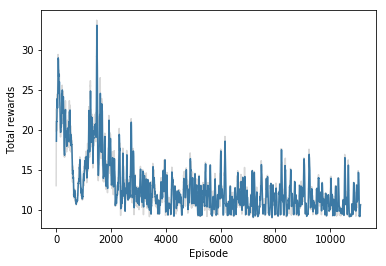

In [31]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

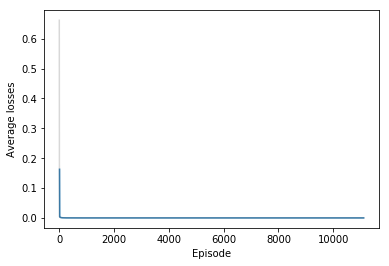

In [32]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    state = env.reset()
    total_reward = 0
    while True:
        env.render()
        action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                feed_dict = {model.states: state.reshape([1, -1]), 
                                                             model.initial_state: initial_state})
        action = np.argmax(action_logits)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
print('total_reward:{}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.